# Intent classifier assignment

In [13]:
import os
import numpy as np
from nltk.corpus import stopwords
from string import punctuation
from nltk import tokenize
from sklearn import preprocessing
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Reshape, Dropout, Concatenate
from keras.layers import Conv2D, MaxPool2D, Embedding
from keras.models import Model

# nltk.download('stopwords')
# nltk.download('punkt')

GLOVE_ADDR = 'glove/glove_s100.txt'
EMBEDDING_DIM = 100 # Dimensions of Glove word vectors

MAX_VOCABULARY = 20000 # Vocabulary size
MAX_SEQUENCE_LENGTH = 25 # Maximum number of words in a sentence
VALIDATION_RATIO = 0.25

### Pre-processing data

In [14]:
sentences = []
labels = []

with open('data.txt', encoding="utf-8") as fp:
    
    # set of portuguese words that is meaningless for our purpose (o, a, os, as, para, com...)
    stopwords = set(stopwords.words("portuguese") + list(punctuation))
    
    intent = ""
    
    for line in fp:
        sentence = tokenize.word_tokenize(line.lower(), language="portuguese") # tokenize words
        sentence_without_stopwords = [word for word in sentence if word not in stopwords] # remove stopwords

        if len(sentence_without_stopwords) == 0:
            continue
        elif sentence[0] == "intent":
            intent = sentence[2]
        else:
            sentences.append(sentence_without_stopwords)
            labels.append(intent)

# print(sentences)
# print(labels)

In [15]:
train_le = preprocessing.LabelEncoder()
train_le.fit(labels)

print(train_le.classes_)

['competencias' 'definicoes' 'digitalizacao' 'documentacao'
 'processos_administrativos' 'usuario']


In [16]:
label_dict = dict(zip(list(train_le.classes_), train_le.transform(list(train_le.classes_))))
print(label_dict)

labels = train_le.transform(labels) # replace labels with their respective index
# print(labels)

{'competencias': 0, 'definicoes': 1, 'digitalizacao': 2, 'documentacao': 3, 'processos_administrativos': 4, 'usuario': 5}


### Tokenizing text


In [17]:
tokenizer = Tokenizer(num_words=MAX_VOCABULARY)
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
print('Found %s unique tokens (different words minus stopwords).' % len(word_index))

sequences = tokenizer.texts_to_sequences(sentences) # replace words with their respective index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) # adjust every sentence to have the same shape

labels = to_categorical(np.asarray(labels)) # one-hot-encode the labels

print('Data tensor shape:', data.shape)
print('Label tensor shape:', labels.shape)

Found 206 unique tokens (different words minus stopwords).
Data tensor shape: (308, 25)
Label tensor shape: (308, 6)


## Split the data into a training set and a validation set

In [18]:
# shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

# apply ratio and split data in training/validation
num_validation_samples = int(VALIDATION_RATIO * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print(x_train)
print(y_train)

[[  0   0   0 ...  22  25  60]
 [  0   0   0 ...  12   2  78]
 [  0   0   0 ... 128  26 129]
 ...
 [  0   0   0 ...   0  31   1]
 [  0   0   0 ...  11  70  29]
 [  0   0   0 ...   0  69  37]]
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


## Handling GLOVE embedding words

- Download the GLOVE 100 dimensions from http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc [(download)](http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s100.zip)
- Adjust GLOVE_ADDR variable to its path

In [8]:
pretrained_embeddings = {}

print('Indexing word vectors...')
with open(GLOVE_ADDR, encoding='utf-8') as f:
    for line in f:
        try:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            pretrained_embeddings[word] = coefs
        except ValueError:
            # print(ValueError)
            continue

print('Found %s pre-trained word vectors.' % len(pretrained_embeddings))

Indexing word vectors...
Found 929594 pre-trained word vectors.


### Creating embedding_matrix
Matrix containing weight vectors for every token

The values will be initialized with the GLOVE values. Tokens not found in GLOVE will be initialized with zero

In [9]:
print('Preparing embedding matrix...')

num_words = min(MAX_VOCABULARY, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = pretrained_embeddings.get(word)

    # words not found in pretrained_embeddings will be all-zeros
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


print('Embedding matrix shape:', embedding_matrix.shape)

Preparing embedding matrix...
Embedding matrix shape: (207, 100)


## Defining CNN model


In [19]:
filter_sizes = [2,3,5]
num_filters = 512
drop = 0.4

print("Creating Model...")
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                      input_length=MAX_SEQUENCE_LENGTH, trainable=False)(inputs)
reshape = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
preds = Dense(len(label_dict), activation='softmax')(dropout)

# this creates a model that includes inputs and outputs
model = Model(inputs=inputs, outputs=preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()


Creating Model...
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 25, 100)      20700       input_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 25, 100, 1)   0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 24, 1, 512)   102912      reshape_2[0][0]                  
__________________________________________________________________________

## Training model

Train on 231 samples, validate on 77 samples
Epoch 1/15
231/231 [==============================] - 0s 768us/step - loss: 1.7176 - acc: 0.3117 - val_loss: 1.2341 - val_acc: 0.5714
Epoch 2/15
231/231 [==============================] - 0s 302us/step - loss: 0.8949 - acc: 0.7403 - val_loss: 0.7872 - val_acc: 0.7662
Epoch 3/15
231/231 [==============================] - 0s 294us/step - loss: 0.5844 - acc: 0.8485 - val_loss: 0.6250 - val_acc: 0.8182
Epoch 4/15
231/231 [==============================] - 0s 294us/step - loss: 0.4402 - acc: 0.9091 - val_loss: 0.5418 - val_acc: 0.8442
Epoch 5/15
231/231 [==============================] - 0s 298us/step - loss: 0.3417 - acc: 0.9481 - val_loss: 0.4941 - val_acc: 0.8312
Epoch 6/15
231/231 [==============================] - 0s 294us/step - loss: 0.2885 - acc: 0.9437 - val_loss: 0.4664 - val_acc: 0.8442
Epoch 7/15
231/231 [==============================] - 0s 302us/step - loss: 0.2394 - acc: 0.9567 - val_loss: 0.4361 - val_acc: 0.8701
Epoch 8/15
231/23

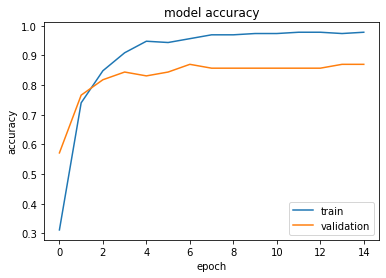

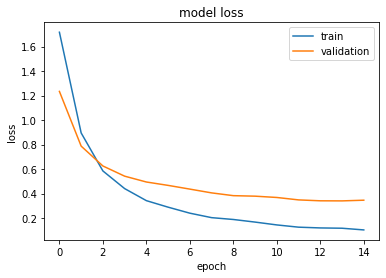

In [20]:
history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=15,
          validation_data=(x_val, y_val))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Testing predictions manually

In [21]:
print("Type the input sentence")
text_input = input().lower()

keywords = tokenize.word_tokenize(text_input, language="portuguese")
keywords = [word for word in keywords if word not in stopwords]

## Processing text to be compatible with model input
test_sequences = tokenizer.texts_to_sequences([keywords])
test_input = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

## Get prediction
test_prediction = model.predict(test_input)
index_ = test_prediction.argmax(axis=-1)[0] # get index of biggest value

print()
print("input:", text_input)
print("keywords:", keywords)
print("intent:", list(label_dict.keys())[index_])
print("confidence: %.2f%%" % (float(test_prediction[0][index_])*100))

Type the input sentence
eu gostaria de saber sobre um documento

input: eu gostaria de saber sobre um documento
keywords: ['gostaria', 'saber', 'sobre', 'documento']
intent: documentacao
confidence: 94.88%


# Notes

***
For this assignment, I supposed that I shouldn't make changes (corrections) in the raw dataset manually, since it wouldn't be productive in a real situation with a larger dataset.

## Pre-processing data
---

The stopwords (o, a, os, as, para, com, ...) from the dataset and the user input were removed.

The dataset provided has many incorrect words. This way, some of them does not match with the words from the pre-trained weights (GLOVE) used in the model.

Cleaning and correcting the words in the dataset (and the user input), should improve the accuracy.

For this, I tried to use RSLPStemmer (nltk) module in portuguese to stem words (remove sufixes).

> `e.g: the boy's cars are different colors -> the boy car be differ color`

However, the portuguese version of nltk is not working very well:

> `e.g: paisagem -> pais`



## Model
---
The model I have chosen(CNN) uses the bag-of-words paradigm, it means that the semantic of the text is not taken into account. The model generates its predictions based in the group of words put together. It is described in this article: https://arxiv.org/abs/1408.5882

I tested the model with both Word2Vec and GLOVE embedding vectors (pre-trained vectors for common words), which can be found in portuguese here:

http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

Word2Vec reached a maximum of 81% val_acc while GLOVE reached 90%.


The model was previously implemented here:https://github.com/ajinkyaT/CNN_Intent_Classification

The author got 99% accuracy using a dataset of 10000 sentences and 6 intentions, while mine has only 300 sentences. This should explain most part the divergence between my result (90%) and his (99%). He used an official dataset which should be clean and free of incorrect words, also the GLOVE embedding is probably better trained in english.

## Training
---
I tested different values for the hyperparameters (batch size, number of filters, drop rate, ...) based on this [paper](https://arxiv.org/abs/1510.03820), and this was the best result.

I used a small number of epochs to avoid overfitting, since it's using a small dataset.